In [1]:
# import all libraries

import torch
print(torch.cuda.is_available())  # Check if GPU is active
print(torch.cuda.get_device_name(0))  # Display GPU nameimport torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

True
NVIDIA A100-SXM4-40GB


Define all paramaters for project.

In [2]:
# paramaters
manual_seed = 111
aguement = False
resume = True
batch_size = 128
epochs = 200
weight_decay = 1e-4
learning_rate = 0.01
use_cuda = True
alpha = 1.0
augment = True

In [3]:
# --- Mixup Functions ---

# basic mixup
def mixup_data_beta(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

# root based mixup
def mixup_data_root(x, y, alpha=1.0):
    lam = np.sqrt(np.random.beta(alpha, alpha))
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

# uniform based mixup
def mixup_data_uniform(x, y,alpha=1.0):
    lam = np.random.uniform(0, 1)
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

# 3 image -multy label- mixup
def mixup_data_multi(x, y, alpha=1.0):
    while True:  # Ensure λ1 + λ2 <= 1
        lam1, lam2 = np.random.beta(alpha, alpha), np.random.beta(alpha, alpha)
        if lam1 + lam2 <= 1:
            break
    lam3 = 1 - lam1 - lam2  # Third weight
    batch_size = x.size(0)
    index1, index2 = torch.randperm(batch_size), torch.randperm(batch_size)
    mixed_x = lam1 * x + lam2 * x[index1, :] + lam3 * x[index2, :]
    return mixed_x, y, y[index1], y[index2], lam1, lam2, lam3


# same label mixup
def same_label_mixup(x, y, alpha=1.0):
  batch_size = x.size(0)
  lam = np.random.beta(alpha, alpha)

  class_indices = {}

  for i in range(batch_size):
    label = y[i].item()
    if label not in class_indices:
      class_indices[label] = []
    class_indices[label].append(i)

  # For each sample, randomly select another sample from the same class
  index = torch.zeros_like(y, dtype=torch.long)
  for i in range(batch_size):
    label = y[i].item()
    same_label_indices = class_indices[label]

    # Remove the current index to avoid mixing with itself
    valid_indices = [idx for idx in same_label_indices if idx != i]

    if valid_indices:  # If there are other samples with the same label
        random_idx = valid_indices[np.random.randint(len(valid_indices))]
        index[i] = random_idx
    else:
        index[i] = i

  mixed_x = lam * x + (1 - lam) * x[index, :]
  return mixed_x, y, y[index], lam

In [4]:
# Using CIFAR-10
# Loading all images from CIFAR-10

# transforms
if augment:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010]),
    ]
)


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse","ship","truck")

# loading train and test sets
train_set = datasets.CIFAR10(root='~/data', train=True, download=True,
                            transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=8)

test_set = datasets.CIFAR10(root='~/data', train=False, download=True,
                           transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                         shuffle=False, num_workers=8)

100%|██████████| 170M/170M [00:02<00:00, 80.7MB/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified


In [5]:
# set device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

cuda


Learning rate adjusment from original papaer.
The learning rate will decrease after 100 and 150 epochs


In [6]:
# learning rate adjusment from original papaer
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Import 2 nets for the project. Both of them were used in the orginal papaer

In [7]:
# import nets
from torchvision.models import resnet18
from torchvision.models import vgg19

#Resnet18
def get_resnet18(num_classes=10):
    net = resnet18(pretrained=False)
    net.fc = nn.Linear(net.fc.in_features, num_classes)  # Adjust output for CIFAR-10
    return net

# VGG19
def get_vgg19(num_classes=10, pretrained=False):
    net = vgg19(pretrained=pretrained)  # Set pretrained=True for pre-trained weights
    net.classifier[6] = nn.Linear(net.classifier[6].in_features, num_classes)
    return net


Saving the a checkpoint of the model.

**Please make sure to set "save_in_drive" parameter to False, the default paramater is set to True, and all checkpoint will be saved in your Google drive.**

Model example: "checkpoint-ResNet18 - Uniform Mixup-2025-02-04__17-16.pth"

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# saving checkpoint of model
import os
from datetime import datetime

def checkpoint(model, model_name, optimizer, epoch, train_loss, train_acc, test_acc, overfitting_rates_list, save_in_drive=True):
 current_datetime = datetime.now().strftime('%Y-%m-%d__%H-%M')
 torch.save({
     'model_name': model_name,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'epoch': epoch,
     'loss': train_loss,  # Optional: loss or other metrics
     'train_acc': train_acc,  # Save training accuracy
     'test_acc': test_acc,    # Save testing accuracy
     'overfitting_rates_list': overfitting_rates_list,
     'date' : datetime.now().strftime('%Y-%m-%d'),
     'time' : datetime.now().strftime('%H-%M')
 }, f'checkpoint-{model_name}-{current_datetime}.pth')
 print(f'Model Saved. File name: checkpoint-{model_name}-{current_datetime}.pth')

 # if save in drive is true, the checkpoint will be saved in "Saved Models" file in your Google Drive
 if save_in_drive:
   save_model_in_drive(model, model_name, optimizer, epoch, train_loss, train_acc, test_acc, overfitting_rates_list)


def save_model_in_drive(model, model_name, optimizer, epoch, train_loss, train_acc, test_acc, overfitting_rates_list):

   # Check if Google Drive is connected
   if not os.path.exists('/content/drive/My Drive'):
       print("Google Drive is not mounted. Mounting it now...")
       drive.mount('/content/drive')

   # Define the path for "Saved Models" in Google Drive
   save_dir = '/content/drive/My Drive/Saved Models'


   # Check if the "Saved_Models" directory exists, and create it if not
   if not os.path.exists(save_dir):
       print(f"'Saved_Models' directory does not exist. Creating it at {save_dir}.")
       os.makedirs(save_dir, exist_ok=True)


   # Save the model checkpoint
   current_datetime = datetime.now().strftime('%Y-%m-%d__%H-%M')
   checkpoint_path = os.path.join(save_dir, f'checkpoint-{model_name}-{current_datetime}.pth')
   torch.save({
       'model_name': model_name,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),
       'epoch': epoch,
       'loss': train_loss,
       'train_acc': train_acc,
       'test_acc': test_acc,
       'overfitting_rates_list': overfitting_rates_list,
       'date' : datetime.now().strftime('%Y-%m-%d'),
       'time' : datetime.now().strftime('%H-%M')
   }, checkpoint_path)

   print(f"Model saved in Drive successfully. File name: checkpoint-{model_name}-{current_datetime}.pth")


Train model function.

Train function has 3 states:
1. train without mixup, no data needs to be mixed
2. train with noraml mixup (2 sample and 3 label are mixed)
3. train with multi-label mixup (3 sample and 3 labels are mixed)

In [9]:
# trafin function
def train(net, optimizer, criterion, train_loader,mixup_function=None):
   net.train()
   train_loss = 0
   correct = 0
   total = 0

   for batch_idx, (inputs, targets) in enumerate(train_loader):
       if use_cuda:
           inputs, targets = inputs.cuda(), targets.cuda()

       if mixup_function:
        mix_data = mixup_function(inputs, targets, alpha)

        # Basic, root-based, unifrom-based and same-label mixup
        if len(mix_data) == 4:
          inputs, targets_a, targets_b, lam = mix_data
          inputs, targets_a, targets_b = map(Variable, (inputs, targets_a, targets_b))
          outputs = net(inputs)
          loss = lam*criterion(outputs, targets_a) + (1-lam)*criterion(outputs, targets_b)

        # multi-label mixup
        elif len(mix_data) == 7:
          inputs, targets_a, targets_b, targets_c, lam1, lam2, lam3 = mix_data
          inputs, targets_a, targets_b, targets_c = map(Variable, (inputs, targets_a, targets_b, targets_c))
          outputs = net(inputs)
          loss = lam1*criterion(outputs, targets_a) + lam2*criterion(outputs, targets_b) + lam3*criterion(outputs, targets_c)

       # no mixup
       else:
          inputs, targets = Variable(inputs), Variable(targets)
          outputs = net(inputs)
          loss = criterion(outputs, targets)

       train_loss += loss.item()
       _, predicted = torch.max(outputs.data, 1)

       total += targets.size(0)

       # Basic, root-based, unifrom-based and same-label mixup
       if mixup_function and len(mix_data)==4:
         correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                     + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

      # multi-label mixup
       elif mixup_function and len(mix_data)==7:
         correct += (lam1 * predicted.eq(targets_a.data).cpu().sum().float()
                     + (lam2) * predicted.eq(targets_b.data).cpu().sum().float()
                          + (lam3) * predicted.eq(targets_c.data).cpu().sum().float())
       # no mixup
       else:
         correct += predicted.eq(targets.data).cpu().sum()

       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

   return (train_loss/batch_idx, 100.*correct/total)


In [10]:
# evaluation the model after each epoch
def test(net, test_loader):
   net.eval()
   test_loss = 0
   correct = 0
   total = 0
   for batch_idx, (inputs, targets) in enumerate(test_loader):
       if use_cuda:
           inputs, targets = inputs.cuda(), targets.cuda()
       inputs, targets = Variable(inputs, volatile=True), Variable(targets)
       outputs = net(inputs)
       loss = criterion(outputs, targets)

       test_loss += loss.data.item()
       _, predicted = torch.max(outputs.data, 1)
       total += targets.size(0)
       correct += predicted.eq(targets.data).cpu().sum()

   return (test_loss/batch_idx, 100.*correct/total)

Mixup methods

In [13]:
methods = {
  "No Mixup": None,
  "Standard Mixup": mixup_data_beta,
  "Root-Based Mixup": mixup_data_root,
  "Uniform Mixup": mixup_data_uniform,
  "Multi-Sample Mixup": mixup_data_multi,
  "Same Label Mixup": same_label_mixup
}
results = {}

Example of tarining - VGG19.

**Train only 10 epochs for example.**

In [14]:
# train only for 10 epochs.
epochs = 10

# crate new net for each mixupmethod
for name_method, method in methods.items():
  net = get_vgg19().to(device)
  train_acc_list = []
  test_acc_list = []
  overfitting_rates_list = []
  loss_list = []
  model_name = f"VGG19 - {name_method}"
  print(model_name)

  # using SDG and CroosEntropyLoss - like in the orginal papaer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
  criterion = nn.CrossEntropyLoss()

  # start training
  for epoch in range(epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train(net, optimizer, criterion, train_loader,method) # actual train
    test_loss, test_acc = test(net, test_loader) # test
    loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    overfitting_rates_list.append(train_acc - test_acc)

    print(f"Epoch [{epoch + 1}/{epochs}]: Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    # save checkpoint every 50 epochs. DO NOT save in drive
    last_epoch = (epoch == epochs - 1)
    if (epoch % 50 == 0 and epoch != 0) or (last_epoch):
      checkpoint(net, model_name, optimizer, epoch, loss_list, train_acc_list, test_acc_list, overfitting_rates_list, save_in_drive=False)

  # save final resutls for each net
  results[model_name] = {
      "train_acc": train_acc_list,
      "test_acc": test_acc_list,
      "overfitting_rate": overfitting_rates_list,
      "loss": loss_list,
  }

VGG19 - No Mixup


<ipython-input-10-6b88f097d4b8>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)


Epoch [1/10]: Loss: 2.0612, Train Accuracy: 22.0500, Test Accuracy: 32.6700
Epoch [2/10]: Loss: 1.6223, Train Accuracy: 38.1820, Test Accuracy: 45.5200
Epoch [3/10]: Loss: 1.3531, Train Accuracy: 50.4980, Test Accuracy: 56.9900
Epoch [4/10]: Loss: 1.1482, Train Accuracy: 59.1220, Test Accuracy: 66.7500
Epoch [5/10]: Loss: 0.9959, Train Accuracy: 64.7800, Test Accuracy: 69.2800
Epoch [6/10]: Loss: 0.8918, Train Accuracy: 68.9380, Test Accuracy: 71.2800
Epoch [7/10]: Loss: 0.7989, Train Accuracy: 72.3980, Test Accuracy: 71.3800
Epoch [8/10]: Loss: 0.7288, Train Accuracy: 75.1400, Test Accuracy: 76.2200
Epoch [9/10]: Loss: 0.6806, Train Accuracy: 76.7880, Test Accuracy: 78.5900
Epoch [10/10]: Loss: 0.6218, Train Accuracy: 79.0720, Test Accuracy: 79.7100
Model Saved. File name: checkpoint-VGG19 - No Mixup-2025-02-21__12-00.pth
VGG19 - Standard Mixup
Epoch [1/10]: Loss: 2.2145, Train Accuracy: 15.4646, Test Accuracy: 27.2700
Epoch [2/10]: Loss: 2.0379, Train Accuracy: 23.6697, Test Accuracy

Loading our trained models.

**DO NOT load them when you run the code.**

Each model is over 1GB.

In [19]:
# ResNet18 models
ResNet18_Uniform_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-RestNet18 - Uniform Mixup-2025-01-04__17-16.pth")
ResNet18_Standard_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-RestNet18 - Standard Mixup-2025-01-04__16-15.pth")
ResNet18_Same_Label_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-RestNet18 - Same Label Mixup-2025-01-10__10-30.pth")
ResNet18_Root_Based_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-RestNet18 - Root-Based Mixup-2025-01-04__16-49.pth")
ResNet18_No_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-RestNet18 - No Mixup-2025-01-04__15-18.pth")
ResNet18_Multi_Sample_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-RestNet18 - Multi-Sample Mixup-2025-01-04__17-44.pth")

# VGG19 models
VGG_Uniform_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-get_vgg19() - Uniform Mixup-2025-01-10__13-35.pth")
VGG_Standard_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-get_vgg19() - Standard Mixup-2025-01-10__12-39.pth")
VGG_Same_Label_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-get_vgg19() - Same Label Mixup-2025-01-10__15-24.pth")
VGG_Root_Based_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-get_vgg19() - Root-Based Mixup-2025-01-10__13-01.pth")
VGG_No_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-get_vgg19() - No Mixup-2025-01-10__11-39.pth")
VGG_Multi_Sample_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-get_vgg19() - Multi-Sample Mixup-2025-01-10__14-12.pth")

# update multi sample to overfitting rates
ResNet18_Same_Label_Mixup['overfitting_rates'] = ResNet18_Same_Label_Mixup['overfitting_rates_list']


<ipython-input-19-7d2f399af0ea>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ResNet18_Uniform_Mixup = torch.load("/content/drive/MyDrive/Final Models/Copy of checkpoint-

In [23]:
ResNet_models = {

    "ResNet18_No_Mixup": ResNet18_No_Mixup,
    "ResNet18_Standard_Mixup": ResNet18_Standard_Mixup,
    "ResNet18_Root_Based_Mixup": ResNet18_Root_Based_Mixup,
    "ResNet18_Uniform_Mixup": ResNet18_Uniform_Mixup,
    "ResNet18_Multi_Sample_Mixup": ResNet18_Multi_Sample_Mixup,
    "ResNet18_Same_Label_Mixup": ResNet18_Same_Label_Mixup,
}
VGG_models = {

    "VGG_No_Mixup": VGG_No_Mixup,
    "VGG_Standard_Mixup": VGG_Standard_Mixup,
    "VGG_Root_Based_Mixup": VGG_Root_Based_Mixup,
    "VGG_Uniform_Mixup": VGG_Uniform_Mixup,
    "VGG_Multi_Sample_Mixup": VGG_Multi_Sample_Mixup,
    "VGG_Same_Label_Mixup": VGG_Same_Label_Mixup
}

Calculating highest ACC for each model, precision and recall

In [24]:
# highest acc
ResNet_models_test_acc = {
    "ResNet18_No_Mixup": ResNet18_No_Mixup['test_acc'],
    "ResNet18_Standard_Mixup": ResNet18_Standard_Mixup['test_acc'],
    "ResNet18_Root_Based_Mixup": ResNet18_Root_Based_Mixup['test_acc'],
    "ResNet18_Uniform_Mixup": ResNet18_Uniform_Mixup['test_acc'],
    "ResNet18_Multi_Sample_Mixup": ResNet18_Multi_Sample_Mixup['test_acc'],
    "ResNet18_Same_Label_Mixup": ResNet18_Same_Label_Mixup['test_acc']
}

VGG_models_test_acc = {
    "VGG_No_Mixup": VGG_No_Mixup['test_acc'],
    "VGG_Standard_Mixup": VGG_Standard_Mixup['test_acc'],
    "VGG_Root_Based_Mixup": VGG_Root_Based_Mixup['test_acc'],
    "VGG_Uniform_Mixup": VGG_Uniform_Mixup['test_acc'],
    "VGG_Multi_Sample_Mixup": VGG_Multi_Sample_Mixup['test_acc'],
    "VGG_Same_Label_Mixup": VGG_Same_Label_Mixup['test_acc']
}

print("Max ACC - ResNet18")
for model_name, test_acc in ResNet_models_test_acc.items():
    max_value = max(torch.max(tensor) for tensor in test_acc)
    print(f"The maximum value in {model_name} is: {max_value.item()}")

print("Max ACC - VGG")
for model_name, test_acc in VGG_models_test_acc.items():
    max_value = max(torch.max(tensor) for tensor in test_acc)
    print(f"The maximum value in {model_name} is: {max_value.item()}")

Max ACC - ResNet18
The maximum value in ResNet18_No_Mixup is: 85.55999755859375
The maximum value in ResNet18_Standard_Mixup is: 86.5999984741211
The maximum value in ResNet18_Root_Based_Mixup is: 85.8499984741211
The maximum value in ResNet18_Uniform_Mixup is: 86.37999725341797
The maximum value in ResNet18_Multi_Sample_Mixup is: 84.58999633789062
The maximum value in ResNet18_Same_Label_Mixup is: 85.30999755859375
Max ACC - VGG
The maximum value in VGG_No_Mixup is: 91.22000122070312
The maximum value in VGG_Standard_Mixup is: 92.51000213623047
The maximum value in VGG_Root_Based_Mixup is: 92.5199966430664
The maximum value in VGG_Uniform_Mixup is: 92.66999816894531
The maximum value in VGG_Multi_Sample_Mixup is: 91.86000061035156
The maximum value in VGG_Same_Label_Mixup is: 92.05000305175781


In [26]:
# Calculating the prcision and recall
from sklearn.metrics import precision_score, recall_score

def calculate_precision_recall(model, test_loader, device ='cuda'):

  model.eval()
  y_true = []
  y_pred = []

  with torch.no_grad():
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      y_true.extend(targets.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')

  return precision, recall


# Calculating for ResNet18
ResNet18_precision_recall = {}
for model_name, model in ResNet_models.items():
    net = get_resnet18().to(device)
    net.load_state_dict(model['model_state_dict'])
    precision, recall = calculate_precision_recall(net, test_loader, device)

    ResNet18_precision_recall[model_name] = {
        'Precision': precision,
        'Recall': recall
    }

for model_name, metrics in ResNet18_precision_recall.items():
  print(f"{model_name} - Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}")



# Calculating for VGG
VGG_precision_recall = {}
for model_name, model in VGG_models.items():
    net = get_vgg19().to(device)
    net.load_state_dict(model['model_state_dict'])
    precision, recall = calculate_precision_recall(net, test_loader, device)

    VGG_precision_recall[model_name] = {
        'Precision': precision,
        'Recall': recall
    }

for model_name, metrics in VGG_precision_recall.items():
  print(f"{model_name} - Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

ResNet18_No_Mixup - Precision: 0.8541, Recall: 0.8539
ResNet18_Standard_Mixup - Precision: 0.8625, Recall: 0.8610
ResNet18_Root_Based_Mixup - Precision: 0.8495, Recall: 0.8489
ResNet18_Uniform_Mixup - Precision: 0.8582, Recall: 0.8580
ResNet18_Multi_Sample_Mixup - Precision: 0.8389, Recall: 0.8362
ResNet18_Same_Label_Mixup - Precision: 0.8536, Recall: 0.8530


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

VGG_No_Mixup - Precision: 0.9112, Recall: 0.9111
VGG_Standard_Mixup - Precision: 0.9236, Recall: 0.9237
VGG_Root_Based_Mixup - Precision: 0.9237, Recall: 0.9233
VGG_Uniform_Mixup - Precision: 0.9242, Recall: 0.9242
VGG_Multi_Sample_Mixup - Precision: 0.9178, Recall: 0.9176
VGG_Same_Label_Mixup - Precision: 0.9206, Recall: 0.9203


In [29]:
# plot charts

def plot_metric(models_dict, metric_name, title):
  plt.figure(figsize=(8, 4))

  for model_name, model_state in models_dict.items():
    metric_values = [tensor.item() for tensor in model_state[metric_name]]
    epochs = list(range(1, len(metric_values) + 1))

    plt.plot(epochs, metric_values, label=model_name, linewidth=2, markersize=4)

  plt.title(title, fontsize=14, pad=20)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel(metric_name.replace('_', ' ').title(), fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.legend(loc='best')
  plt.tight_layout()

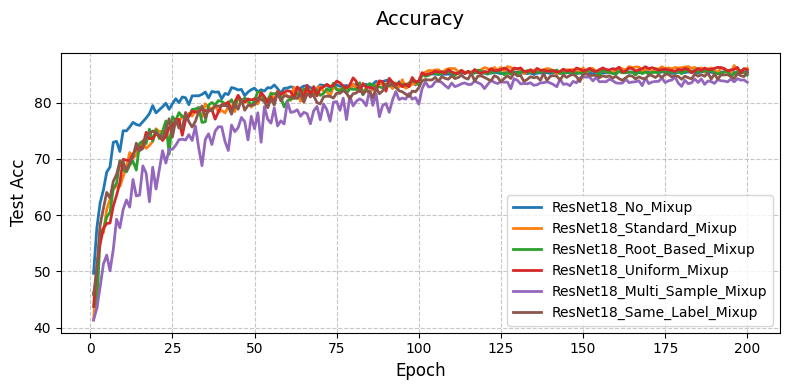

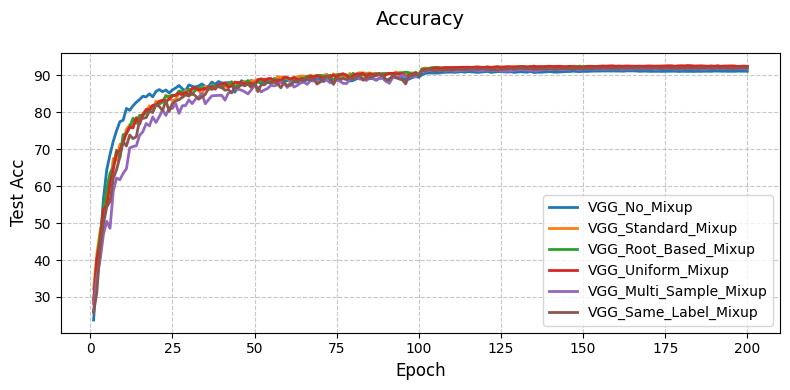

In [30]:
# ACC for each model
plot_metric(ResNet_models, "test_acc", "Accuracy")
plot_metric(VGG_models, "test_acc", "Accuracy")